# Group Project: Developing An Intelligent Application for Skin Disease Classification Using Deep Learning Techniques

Purpose: apply all the accumulated knowledge learned throughout the term and get
some hands-on-experience in applying the deep learning techniques and concepts
to a real-world problem.

**Skin Disease Dataset:**

This dataset is a diverse collection of images representing various skin diseases, meticulously categorized into 22 distinct classe
The images are meticulously categorized into 22 distinct classes, each corresponding to a specific skin condition:

Acne

Actinic Keratosis

Benign Tumors

Bullous

Candidiasis

Drug Eruption

Eczema

Infestations/Bites

Lichen

Lupus

Moles

Psoriasis

Rosacea

Seborrheic Keratoses

Skin Cancer

Sun/Sunlight Damage

Tinea

Unknown/Normal

Vascular Tumors

Vasculitis

Vitiligo

Warts

# 1. Data Preparation and Exploration

**1.1 Environment setup**

In [ ]:
# Import dependencies
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

**1.2 Dataset Loading**

In [ ]:
# Define the directory where the dataset will be stored
train_dataset = "/content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/data/original data/train_original_data"
validation_dataset = "/content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/data/original data/val_original_data"
test_dataset = "/content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/data/original data/test_original_data"

**1.3. Data Exploration and Visualization**

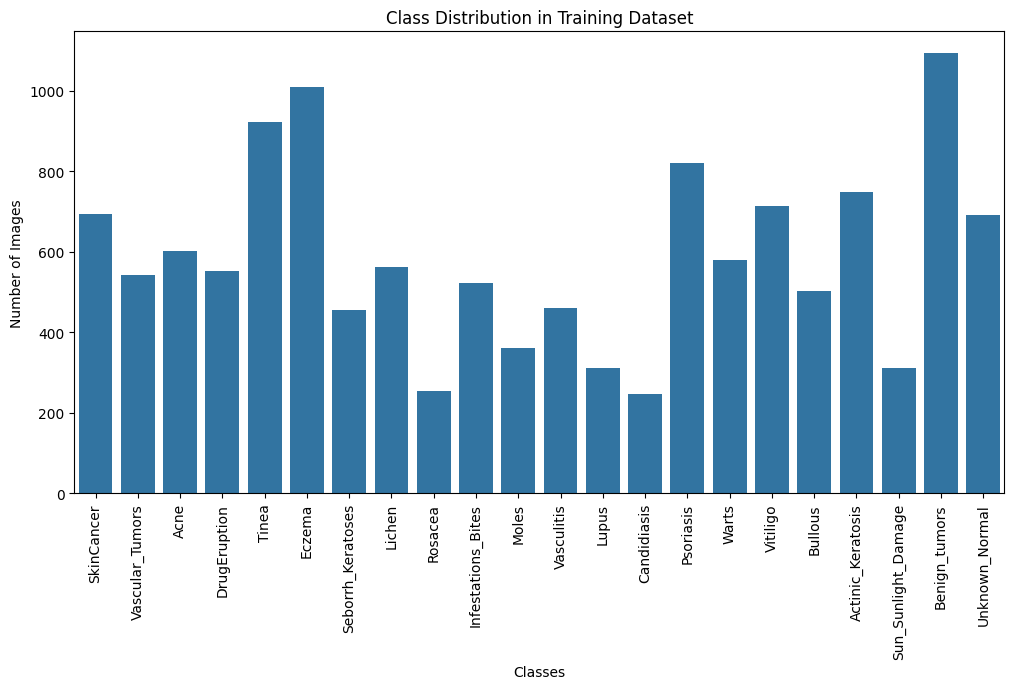

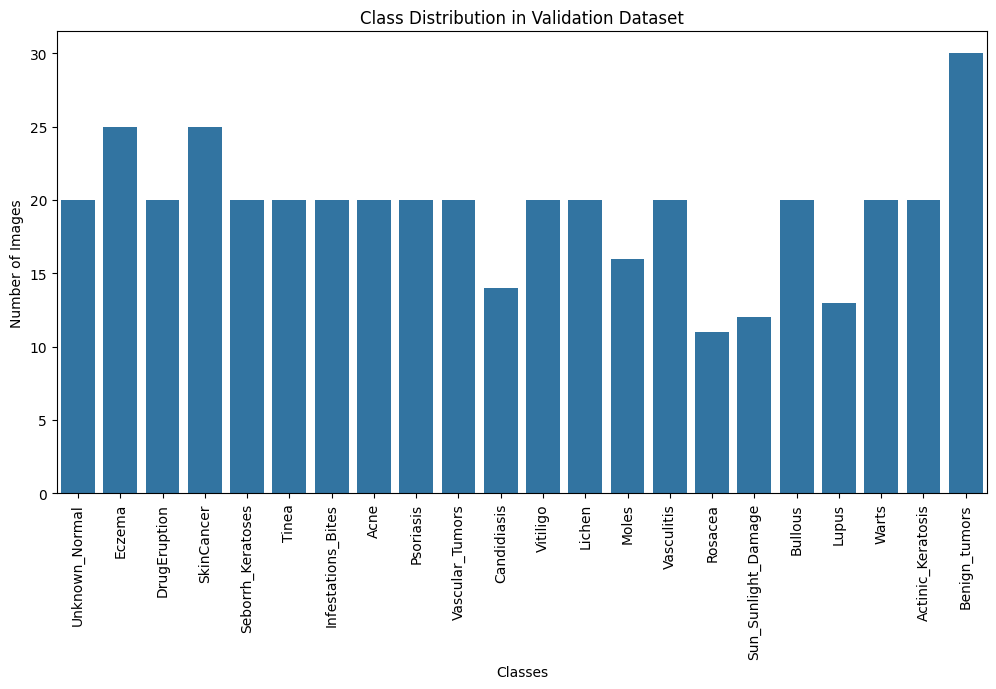

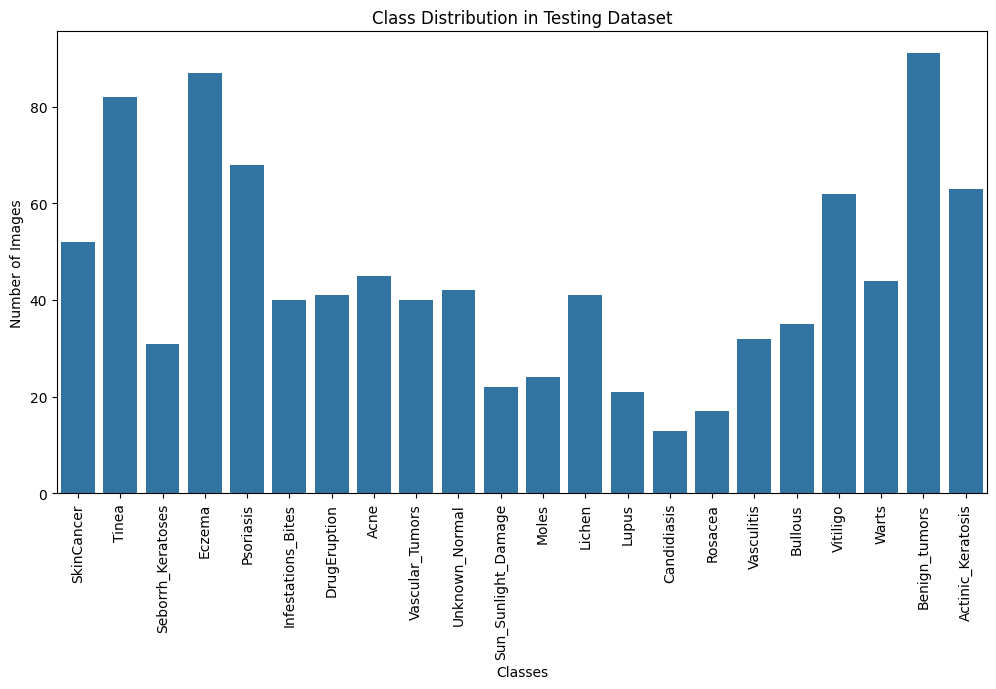

In [ ]:
# Function to get class distribution
def get_class_distribution(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Get class distributions for train and test datasets
train_class_distribution = get_class_distribution(train_dataset)
validation_class_distribution = get_class_distribution(validation_dataset)
test_class_distribution = get_class_distribution(test_dataset)

# Plot class distribution
def plot_class_distribution(distribution, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(distribution.keys()), y=list(distribution.values()))
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.show()

plot_class_distribution(train_class_distribution, "Class Distribution in Training Dataset")
plot_class_distribution(validation_class_distribution, "Class Distribution in Validation Dataset")
plot_class_distribution(test_class_distribution, "Class Distribution in Testing Dataset")

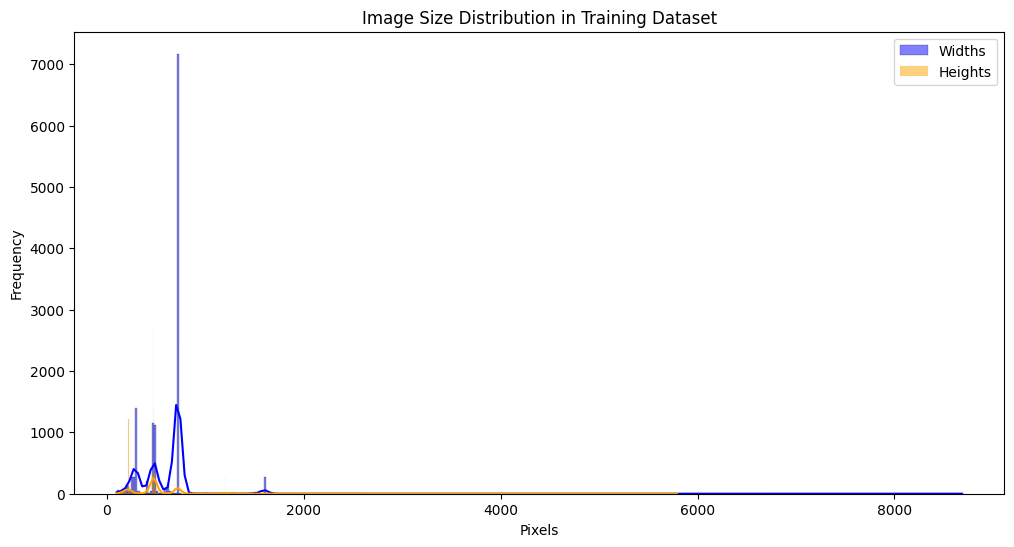

In [ ]:
# Function to analyze image sizes
def analyze_image_sizes(dataset_path):
    image_sizes = []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                with Image.open(image_path) as img:
                    image_sizes.append(img.size)
    return image_sizes

# Analyze image sizes in the training dataset
train_image_sizes = analyze_image_sizes(train_dataset)

# Plot image size distribution
def plot_image_size_distribution(image_sizes, title):
    widths, heights = zip(*image_sizes)
    plt.figure(figsize=(12, 6))
    sns.histplot(widths, kde=True, color="blue", label="Widths")
    sns.histplot(heights, kde=True, color="orange", label="Heights")
    plt.title(title)
    plt.xlabel("Pixels")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

plot_image_size_distribution(train_image_sizes, "Image Size Distribution in Training Dataset")

In [ ]:
# Function to visualize sample images from each class
def visualize_sample_images(dataset_path, num_samples=1):
    plt.figure(figsize=(15, 15))
    class_names = os.listdir(dataset_path)
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            image_name = os.listdir(class_path)[6]
            image_path = os.path.join(class_path, image_name)
            with Image.open(image_path) as img:
                plt.subplot(5, 5, i + 1)
                plt.imshow(img)
                plt.title(class_name)
                plt.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize sample images from the training dataset
visualize_sample_images(train_dataset)

Output hidden; open in https://colab.research.google.com to view.

# 2. Data Preprocessing

In [ ]:
# Implement image preprocessing including resizing, normalization,

# Define image dimensions and batch size
IMAGE_SIZE = (224, 224)  # 224x224 is a good standard size for most CNN architectures
BATCH_SIZE = 32

# Create simple ImageDataGenerator with only rescaling (normalization)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Create data generators for training and validation datasets
train_generator = data_generator.flow_from_directory(
    train_dataset,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

validation_generator = data_generator.flow_from_directory(
    validation_dataset,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Display information about the generators
print(f"Training generator: Found {train_generator.samples} images belonging to {len(train_generator.class_indices)} classes")
print(f"Validation generator: Found {validation_generator.samples} images belonging to {len(validation_generator.class_indices)} classes")

Found 12964 images belonging to 22 classes.
Found 426 images belonging to 22 classes.
Training generator: Found 12964 images belonging to 22 classes
Validation generator: Found 426 images belonging to 22 classes


# 3. Supervised Learning: Custom CNN Implementation

**3.1 Custom CNN model architecture**

In [ ]:
# Design and implement a custom CNN architecture for skin disease classification.
def create_improved_cnn(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # First block
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Second block
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Third block
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Fourth block
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Classification block
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

**3.2 Build Custom CNN Model**

In [ ]:
# Get input shape and number of classes from the data generator
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)  # RGB images
num_classes = train_generator.num_classes

# Create the improved model
model = create_improved_cnn(input_shape, num_classes)

# Compile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001,
    verbose=1
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/best_custom_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 56,213,846 (214.44 MB)

 Trainable params: 56,208,470 (214.42 MB)

 Non-trainable params: 5,376 (21.00 KB)

**3.3 Custom Model Training**

In [ ]:
# Train with more epochs
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.0945 - loss: 3.7583
Epoch 1: val_accuracy improved from -inf to 0.07981, saving model to /content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/best_custom_model.keras
406/406 ━━━━━━━━━━━━━━━━━━━━ 3288s 8s/step - accuracy: 0.0946 - loss: 3.7576 - val_accuracy: 0.0798 - val_loss: 3.6328 - learning_rate: 0.0010
Epoch 2/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.1585 - loss: 2.9538
Epoch 2: val_accuracy improved from 0.07981 to 0.17136, saving model to /content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/best_custom_model.keras
406/406 ━━━━━━━━━━━━━━━━━━━━ 89s 214ms/step - accuracy: 0.1585 - loss: 2.9536 - val_accuracy: 0.1714 - val_loss: 2.7359 - learning_rate: 0.0010
Epoch 3/50
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.2158 - loss: 2.6512
Epoch 3: val_accuracy improved from 0.17136 to 0.24648, saving model to /content/drive/MyDrive/

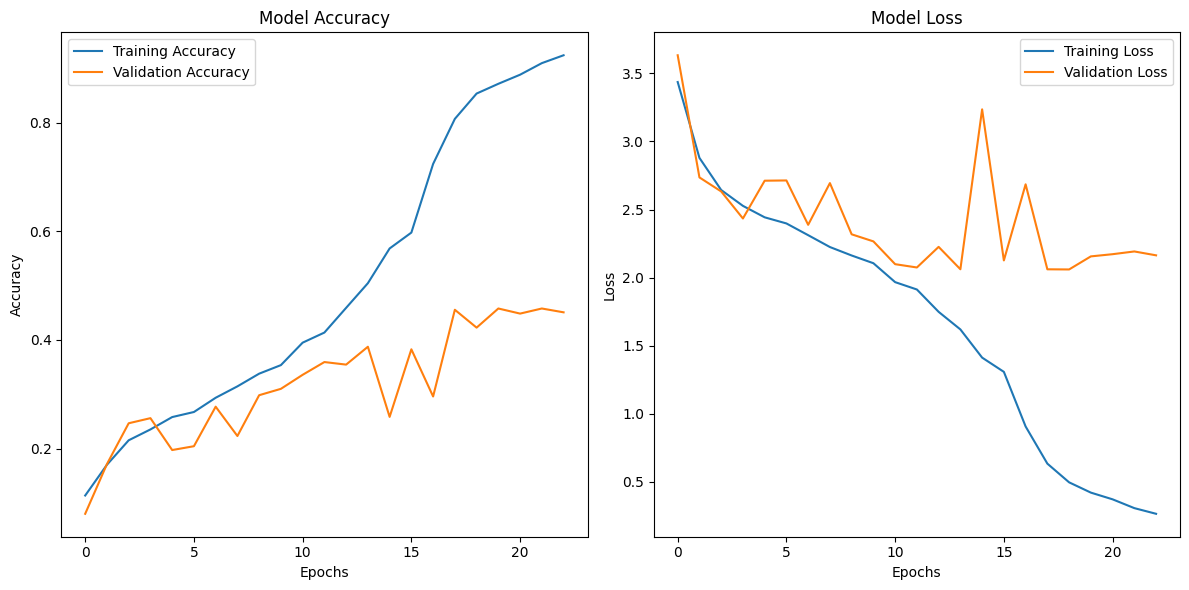

In [ ]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# 4. Unsupervised Learning: Autoencoder for Feature Extraction

**4.1 Autoencoder Architecture**

In [ ]:
# Implement an autoencoder architecture for unsupervised feature learning from skin disease images.

# Define the autoencoder architecture
def create_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = Model(input_img, decoded)

    # Encoder model for feature extraction
    encoder = Model(input_img, encoded)

    return autoencoder, encoder

**4.2 Model Buildind**

In [ ]:
# Create the autoencoder and encoder models
autoencoder, encoder = create_autoencoder((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Compile the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Create checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/autoencoder_best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

**4.3 Data Preparation**

In [ ]:
# Create special data generators for autoencoder training
autoencoder_train_gen = ImageDataGenerator(rescale=1.0/255.0)
autoencoder_val_gen = ImageDataGenerator(rescale=1.0/255.0)

# These generators will return (image, image) pairs
autoencoder_train_data = autoencoder_train_gen.flow_from_directory(
    train_dataset,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=True
)

autoencoder_val_data = autoencoder_val_gen.flow_from_directory(
    validation_dataset,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

# Custom generator to return (image, image) pairs
def autoencoder_generator(gen):
    for batch in gen:
        yield (batch, batch)

Found 12964 images belonging to 22 classes.
Found 426 images belonging to 22 classes.


**4.4 Model Training**

In [ ]:
# Train the autoencoder
autoencoder_history = autoencoder.fit(
    autoencoder_generator(autoencoder_train_data),
    steps_per_epoch=len(autoencoder_train_data),
    validation_data=autoencoder_generator(autoencoder_val_data),
    validation_steps=len(autoencoder_val_data),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        checkpoint
    ],
    verbose=1
)

Epoch 1/15
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0308
Epoch 1: val_loss improved from inf to 0.00392, saving model to /content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/autoencoder_best_model.keras
406/406 ━━━━━━━━━━━━━━━━━━━━ 78s 179ms/step - loss: 0.0307 - val_loss: 0.0039
Epoch 2/15
405/406 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0037
Epoch 2: val_loss improved from 0.00392 to 0.00328, saving model to /content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/autoencoder_best_model.keras
406/406 ━━━━━━━━━━━━━━━━━━━━ 68s 167ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 3/15
405/406 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0032
Epoch 3: val_loss improved from 0.00328 to 0.00299, saving model to /content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/autoencoder_best_model.keras
406/406 ━━━━━━━━━━━━━━━━━━━━ 68s 169ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 4/15
405/406 ━

**4.5 Feature Extraction**

In [ ]:
# Recreate the architecture of the encoder and load weights
autoencoder, encoder = create_autoencoder((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
autoencoder.load_weights('/content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/autoencoder_best_model.keras')

In [ ]:
# Use the loaded encoder to extract features
# First recreate data generators
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
data_generator = ImageDataGenerator(rescale=1.0/255.0)

train_generator = data_generator.flow_from_directory(
    train_dataset,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

validation_generator = data_generator.flow_from_directory(
    validation_dataset,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 12964 images belonging to 22 classes.
Found 426 images belonging to 22 classes.


In [ ]:
# Function to extract features using the trained encoder
def extract_features(data_generator, encoder_model):
    features = []
    labels = []
    batch_count = 0

    # Reset the generator
    data_generator.reset()

    for images, image_labels in data_generator:
        # Extract features for this batch
        batch_features = encoder_model.predict(images)

        # Flatten the features
        batch_features_flat = batch_features.reshape(batch_features.shape[0], -1)

        # Append to lists
        features.append(batch_features_flat)
        labels.append(image_labels)

        batch_count += 1
        if batch_count >= len(data_generator):
            break

    # Concatenate all batches
    return np.concatenate(features), np.concatenate(labels)

# Extract features
X_train, y_train = extract_features(train_generator, encoder)
X_val, y_val = extract_features(validation_generator, encoder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

**4.5 Training Custom CNN Model with Extracted Features**

In [ ]:
# Create a model that uses the classification block from the original CNN
def create_classifier_for_features_extracted(input_dim, num_classes):
    # Input layer for flattened features
    inputs = Input(shape=(input_dim,))

    x = Dense(1024, activation='relu')(inputs)  #
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Get input dimension from extracted features
input_dim = X_train.shape[1]  # This is the flattened feature size
num_classes = y_train.shape[1]  # Number of classes

In [ ]:
# Create the model for extracted features
model_feature_extracted = create_classifier_for_features_extracted(input_dim, num_classes)

# Compile with the same settings as the original CNN
model_feature_extracted.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Same callbacks as before
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=0.000001,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/best_custom_model_with_extracted_features.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
# Train the model on extracted features
feature_history = model_feature_extracted.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=70,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

Epoch 1/70
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1048 - loss: 3.8833
Epoch 1: val_accuracy improved from -inf to 0.14085, saving model to /content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/best_custom_model_with_extracted_features.keras
406/406 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.1048 - loss: 3.8830 - val_accuracy: 0.1408 - val_loss: 3.2792 - learning_rate: 1.0000e-04
Epoch 2/70
402/406 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1422 - loss: 3.4965
Epoch 2: val_accuracy improved from 0.14085 to 0.17606, saving model to /content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/best_custom_model_with_extracted_features.keras
406/406 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.1422 - loss: 3.4959 - val_accuracy: 0.1761 - val_loss: 2.8633 - learning_rate: 1.0000e-04
Epoch 3/70
403/406 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1650 - loss: 3.2733
Epoch 3: val_accuracy did not improve fr

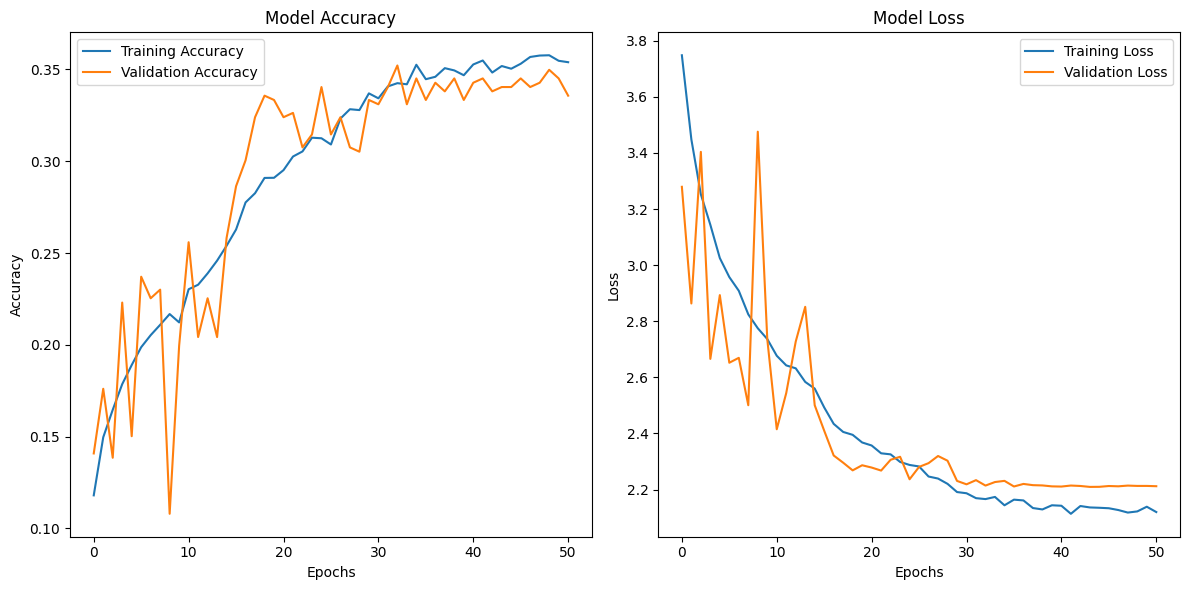

In [ ]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Plot the training history to compare with original CNN
plot_training_history(feature_history)

# 5. State-of-the-Art Model Implementation

**5.1 State-of-the-Art Model Architecture**

In [ ]:
def create_densenet_model(input_shape, num_classes):
    """Create a DenseNet121 model with transfer learning"""
    # Load the pre-trained DenseNet121 without the top classification layer
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the pre-trained weights
    base_model.trainable = False

    # Add custom layers on top
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    return model

**5.2 Data Preparation**

In [ ]:
# Define image dimensions and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Create data generators for training and validation with preprocessing specific to DenseNet121
data_generator_train = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

data_generator_val = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


# Create data generators for training and validation datasets
train_generator_densenet = data_generator_train.flow_from_directory(
    train_dataset,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

validation_generator_densenet = data_generator_val.flow_from_directory(
    validation_dataset,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 12964 images belonging to 22 classes.
Found 426 images belonging to 22 classes.


**5.3 Model set up**

In [ ]:
# Get input shape and number of classes
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
num_classes = train_generator_densenet.num_classes

# Create the DenseNet121 model
densenet_model = create_densenet_model(input_shape, num_classes)

# Compile the model
densenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
densenet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 22)             │         5,654 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,705,430 (29.39 MB)

 Trainable params: 664,854 (2.54 MB)

 Non-trainable params: 7,040,576 (26.86 MB)

In [ ]:
# Define callbacks for training
reduce_lr_densenet = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.000001,
    verbose=1
)

early_stopping_densenet = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

checkpoint_path = '/content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/densenet121_best_model.keras'
model_checkpoint_densenet = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

**5.4 Model Training**

In [ ]:
# Train the DenseNet121 model
history_densenet = densenet_model.fit(
    train_generator_densenet,
    validation_data=validation_generator_densenet,
    epochs=80,
    callbacks=[
        early_stopping_densenet,
        reduce_lr_densenet,
        model_checkpoint_densenet
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.1058 - loss: 3.4789
Epoch 1: val_accuracy improved from -inf to 0.32394, saving model to /content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/densenet121_best_model.keras
406/406 ━━━━━━━━━━━━━━━━━━━━ 123s 242ms/step - accuracy: 0.1059 - loss: 3.4782 - val_accuracy: 0.3239 - val_loss: 2.2629 - learning_rate: 1.0000e-04
Epoch 2/80
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.2302 - loss: 2.7096
Epoch 2: val_accuracy improved from 0.32394 to 0.39906, saving model to /content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/densenet121_best_model.keras
406/406 ━━━━━━━━━━━━━━━━━━━━ 75s 185ms/step - accuracy: 0.2302 - loss: 2.7093 - val_accuracy: 0.3991 - val_loss: 2.0111 - learning_rate: 1.0000e-04
Epoch 3/80
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.2844 - loss: 2.4546
Epoch 3: val_accuracy improved from 0.39906 to 0.41784, saving model to 

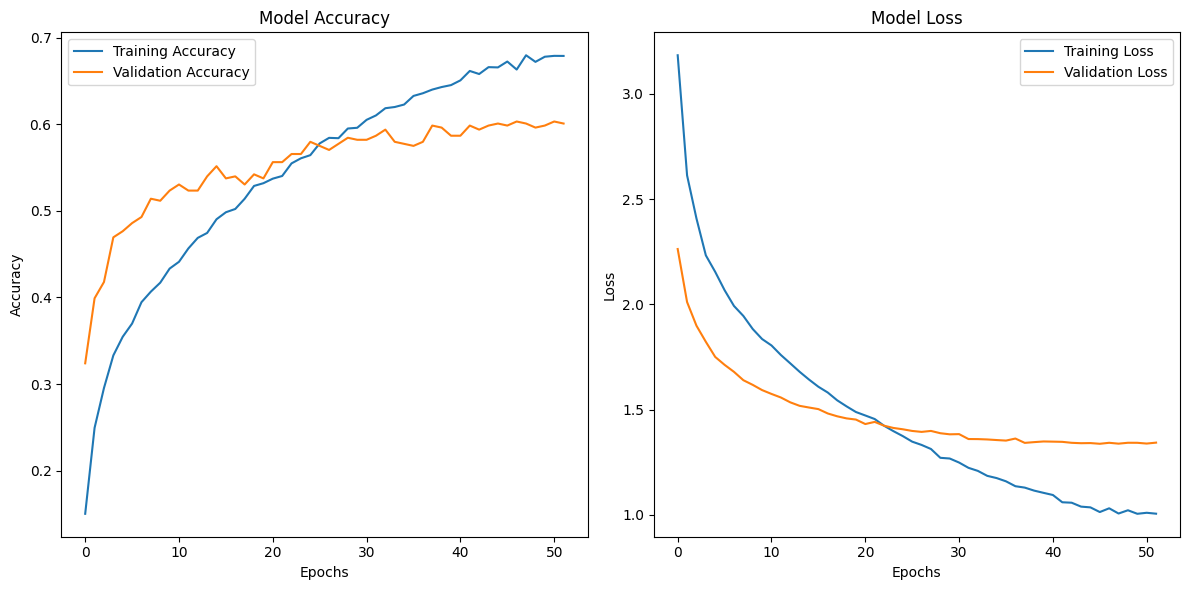

In [ ]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_densenet)

# 6. Model Testing

**6.1 Testing Custom CNN Model**

In [ ]:
# Create test data generator with the same preprocessing used for training
test_data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Create test generator
test_generator = test_data_generator.flow_from_directory(
    test_dataset,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Load the best custom CNN model
best_cnn_model = load_model('/content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/best_custom_model.keras')

Found 993 images belonging to 22 classes.


In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = best_cnn_model.evaluate(test_generator)
print(f"Custom CNN Model - Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 355s 11s/step - accuracy: 0.4400 - loss: 2.1898
Custom CNN Model - Test Accuracy: 0.4441, Test Loss: 2.1693


In [ ]:
# Generate predictions for confusion matrix
test_generator.reset()
y_pred = []
y_true = []

for i in range(len(test_generator)):
    images, labels = test_generator.__next__()
    predictions = best_cnn_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels, axis=1))
    if len(y_true) >= test_generator.samples:
        break

# Get class mapping
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Generate classification report
print("\nClassification Report for Custom CNN Model:")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━

<Figure size 2000x2000 with 0 Axes>

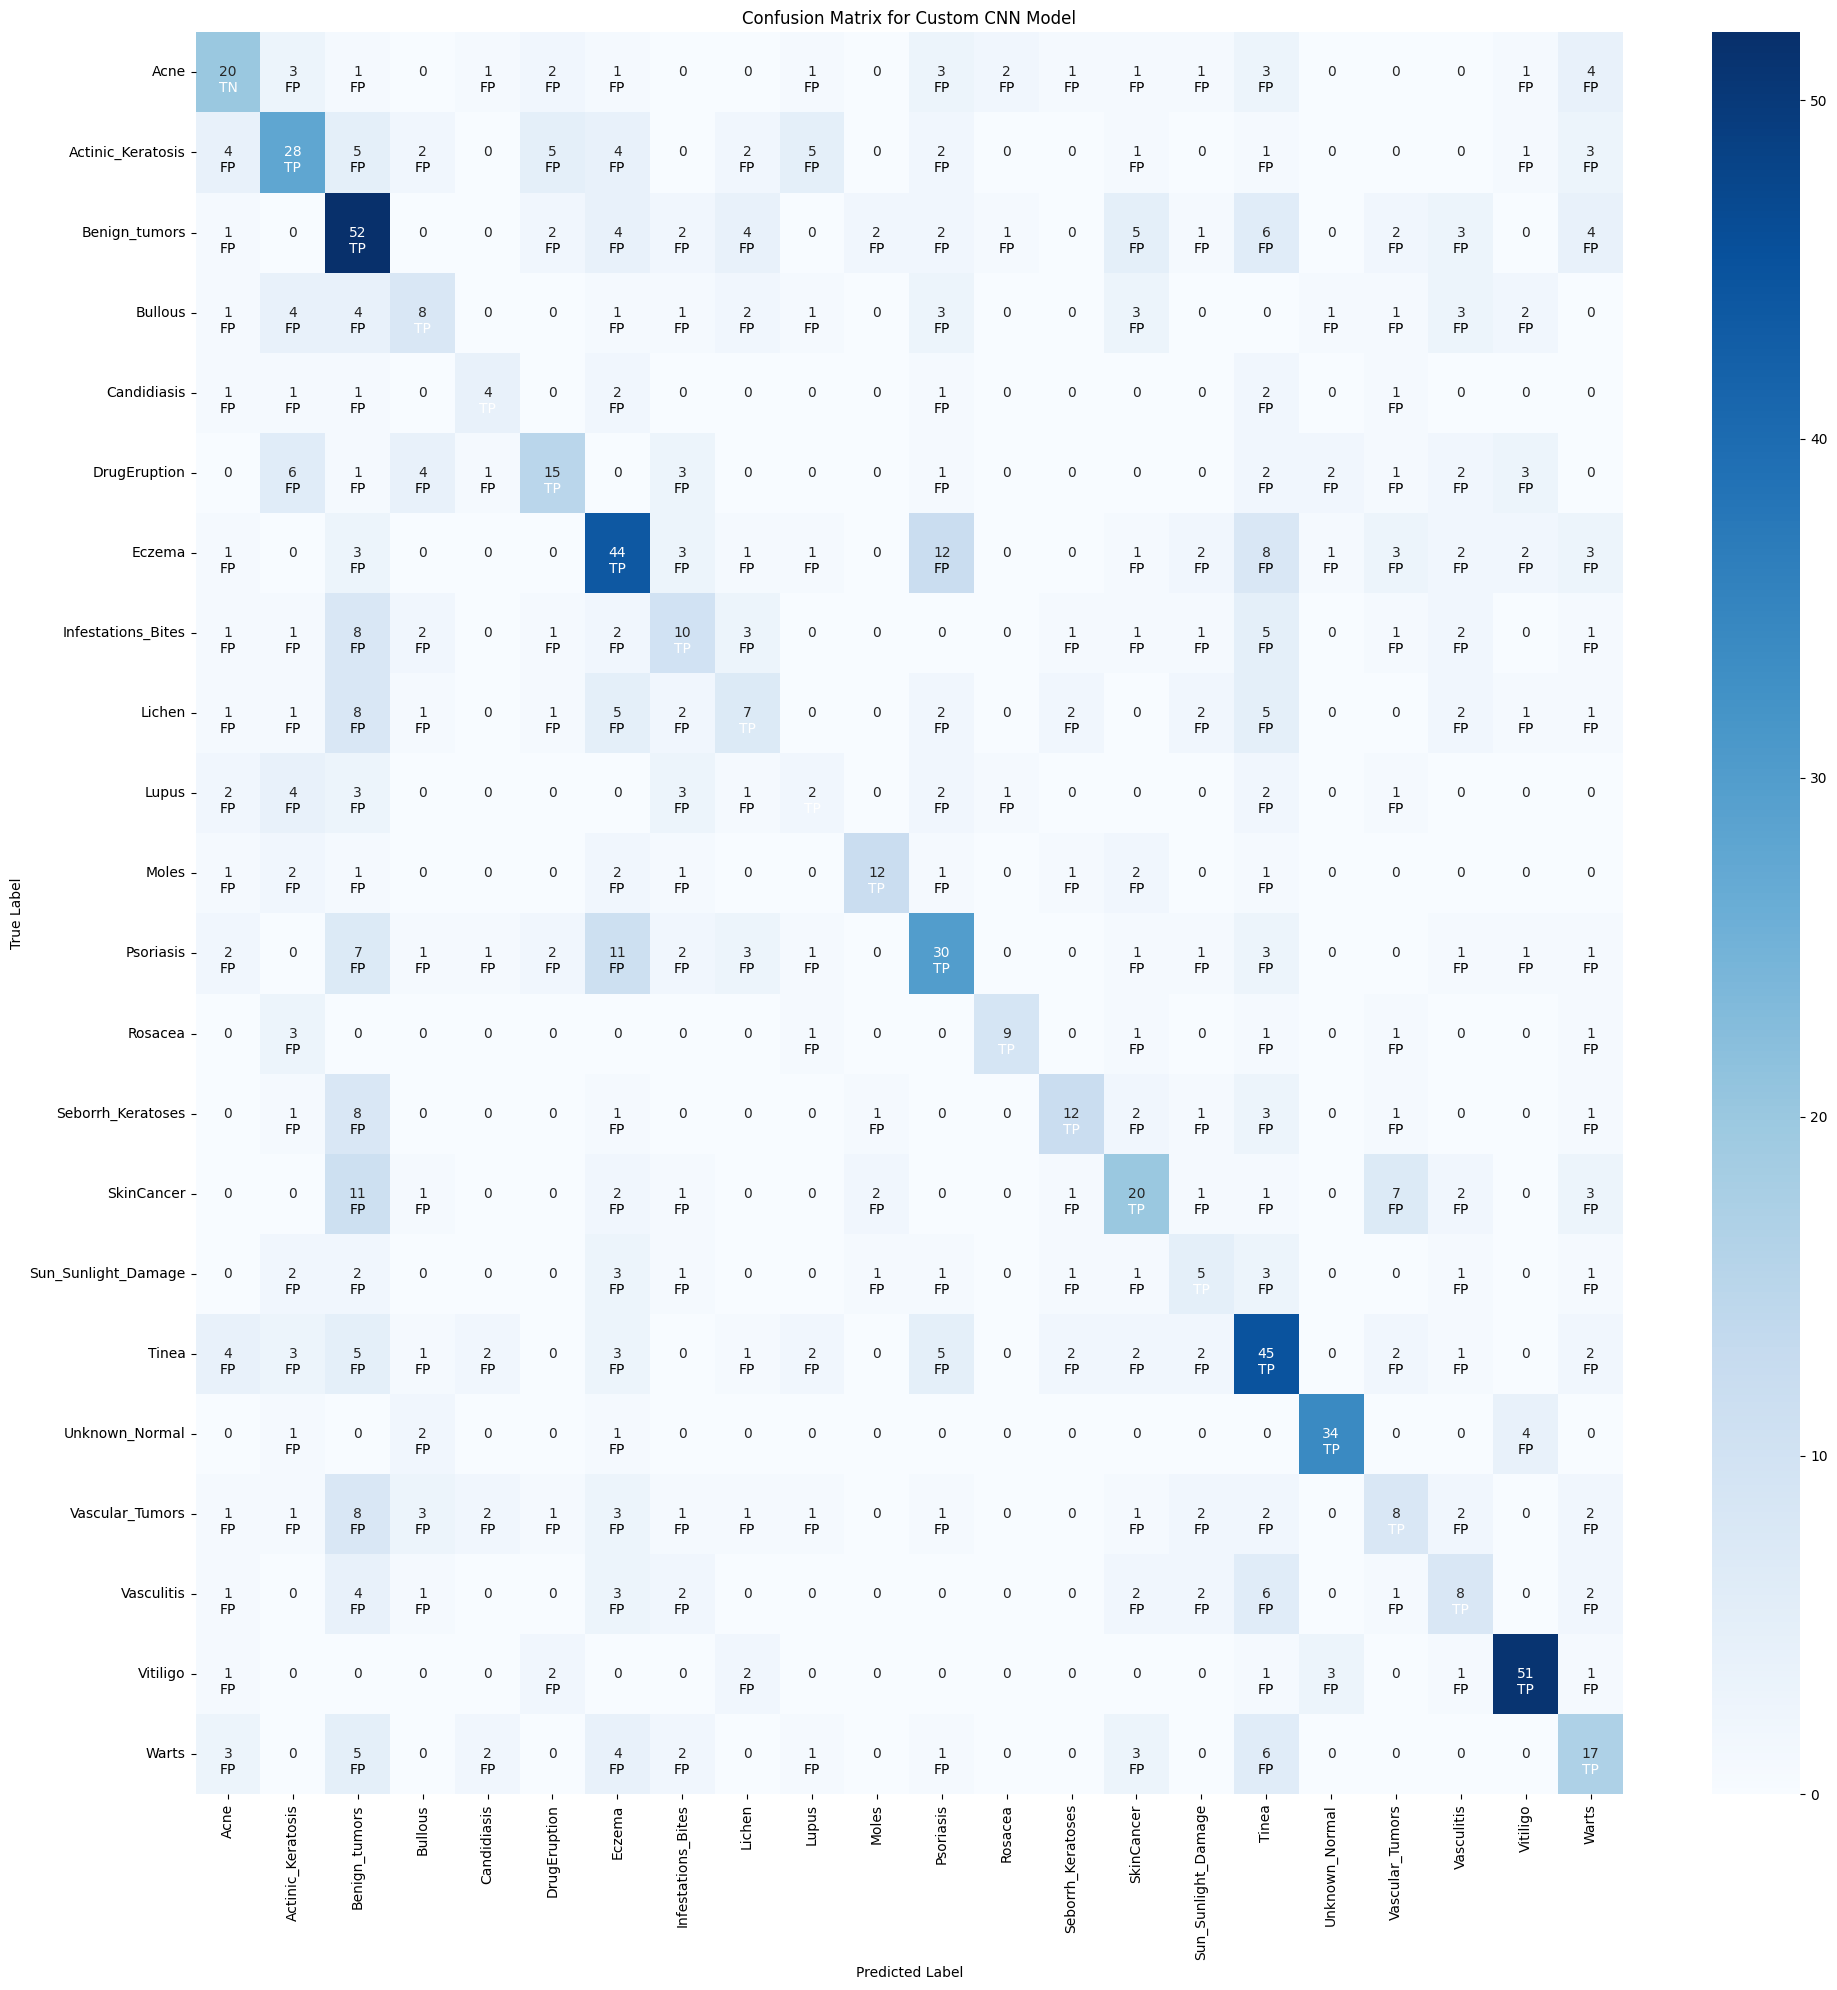

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(20, 20))
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix_with_labels(y_true, y_pred, class_names):
    """Plots a confusion matrix with TP, TN, FP, FN labels."""

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 20))

    # Create heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    # Add labels for TP, TN, FP, FN
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == j:  # True Positives/Negatives
                if cm[i, j] != 0:
                    plt.text(j + 0.5, i + 0.7, 'TP' if i != 0 else 'TN',
                             ha='center', va='center', color='white')
            else:  # False Positives/Negatives
                if cm[i, j] != 0:
                    plt.text(j + 0.5, i + 0.7, 'FP' if i != j else 'FN',
                             ha='center', va='center', color='black')


    plt.title('Confusion Matrix for Custom CNN Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix_with_labels(y_true, y_pred, class_names)

**6.2 Testing Custom Classifier**

In [ ]:
# Load the best model trained on extracted features
best_feature_model = load_model('/content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/best_custom_model_with_extracted_features.keras')

# Create test data generator
test_generator_for_features = test_data_generator.flow_from_directory(
    test_dataset,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Extract features from test data using the encoder
X_test, y_test = extract_features(test_generator_for_features, encoder)

Found 993 images belonging to 22 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━

In [ ]:
# Evaluate the model on test data
test_loss_features, test_accuracy_features = best_feature_model.evaluate(X_test, y_test)
print(f"Feature-based Model - Test Accuracy: {test_accuracy_features:.4f}, Test Loss: {test_loss_features:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3390 - loss: 2.1936
Feature-based Model - Test Accuracy: 0.3182, Test Loss: 2.2111


In [ ]:
# Generate predictions for confusion matrix
y_pred_features = np.argmax(best_feature_model.predict(X_test), axis=1)
y_true_features = np.argmax(y_test, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [ ]:
# Generate classification report
print("\nClassification Report for Feature-based Model:")
print(classification_report(y_true_features, y_pred_features, target_names=class_names))


Classification Report for Feature-based Model:
                     precision    recall  f1-score   support

               Acne       0.24      0.24      0.24        45
  Actinic_Keratosis       0.30      0.35      0.32        63
      Benign_tumors       0.25      0.65      0.36        91
            Bullous       0.21      0.11      0.15        35
        Candidiasis       0.22      0.15      0.18        13
       DrugEruption       0.40      0.34      0.37        41
             Eczema       0.27      0.46      0.34        87
 Infestations_Bites       0.33      0.05      0.09        40
             Lichen       0.38      0.20      0.26        41
              Lupus       0.33      0.14      0.20        21
              Moles       0.29      0.08      0.13        24
          Psoriasis       0.32      0.32      0.32        68
            Rosacea       0.57      0.24      0.33        17
  Seborrh_Keratoses       0.38      0.19      0.26        31
         SkinCancer       0.21      

<Figure size 2000x2000 with 0 Axes>

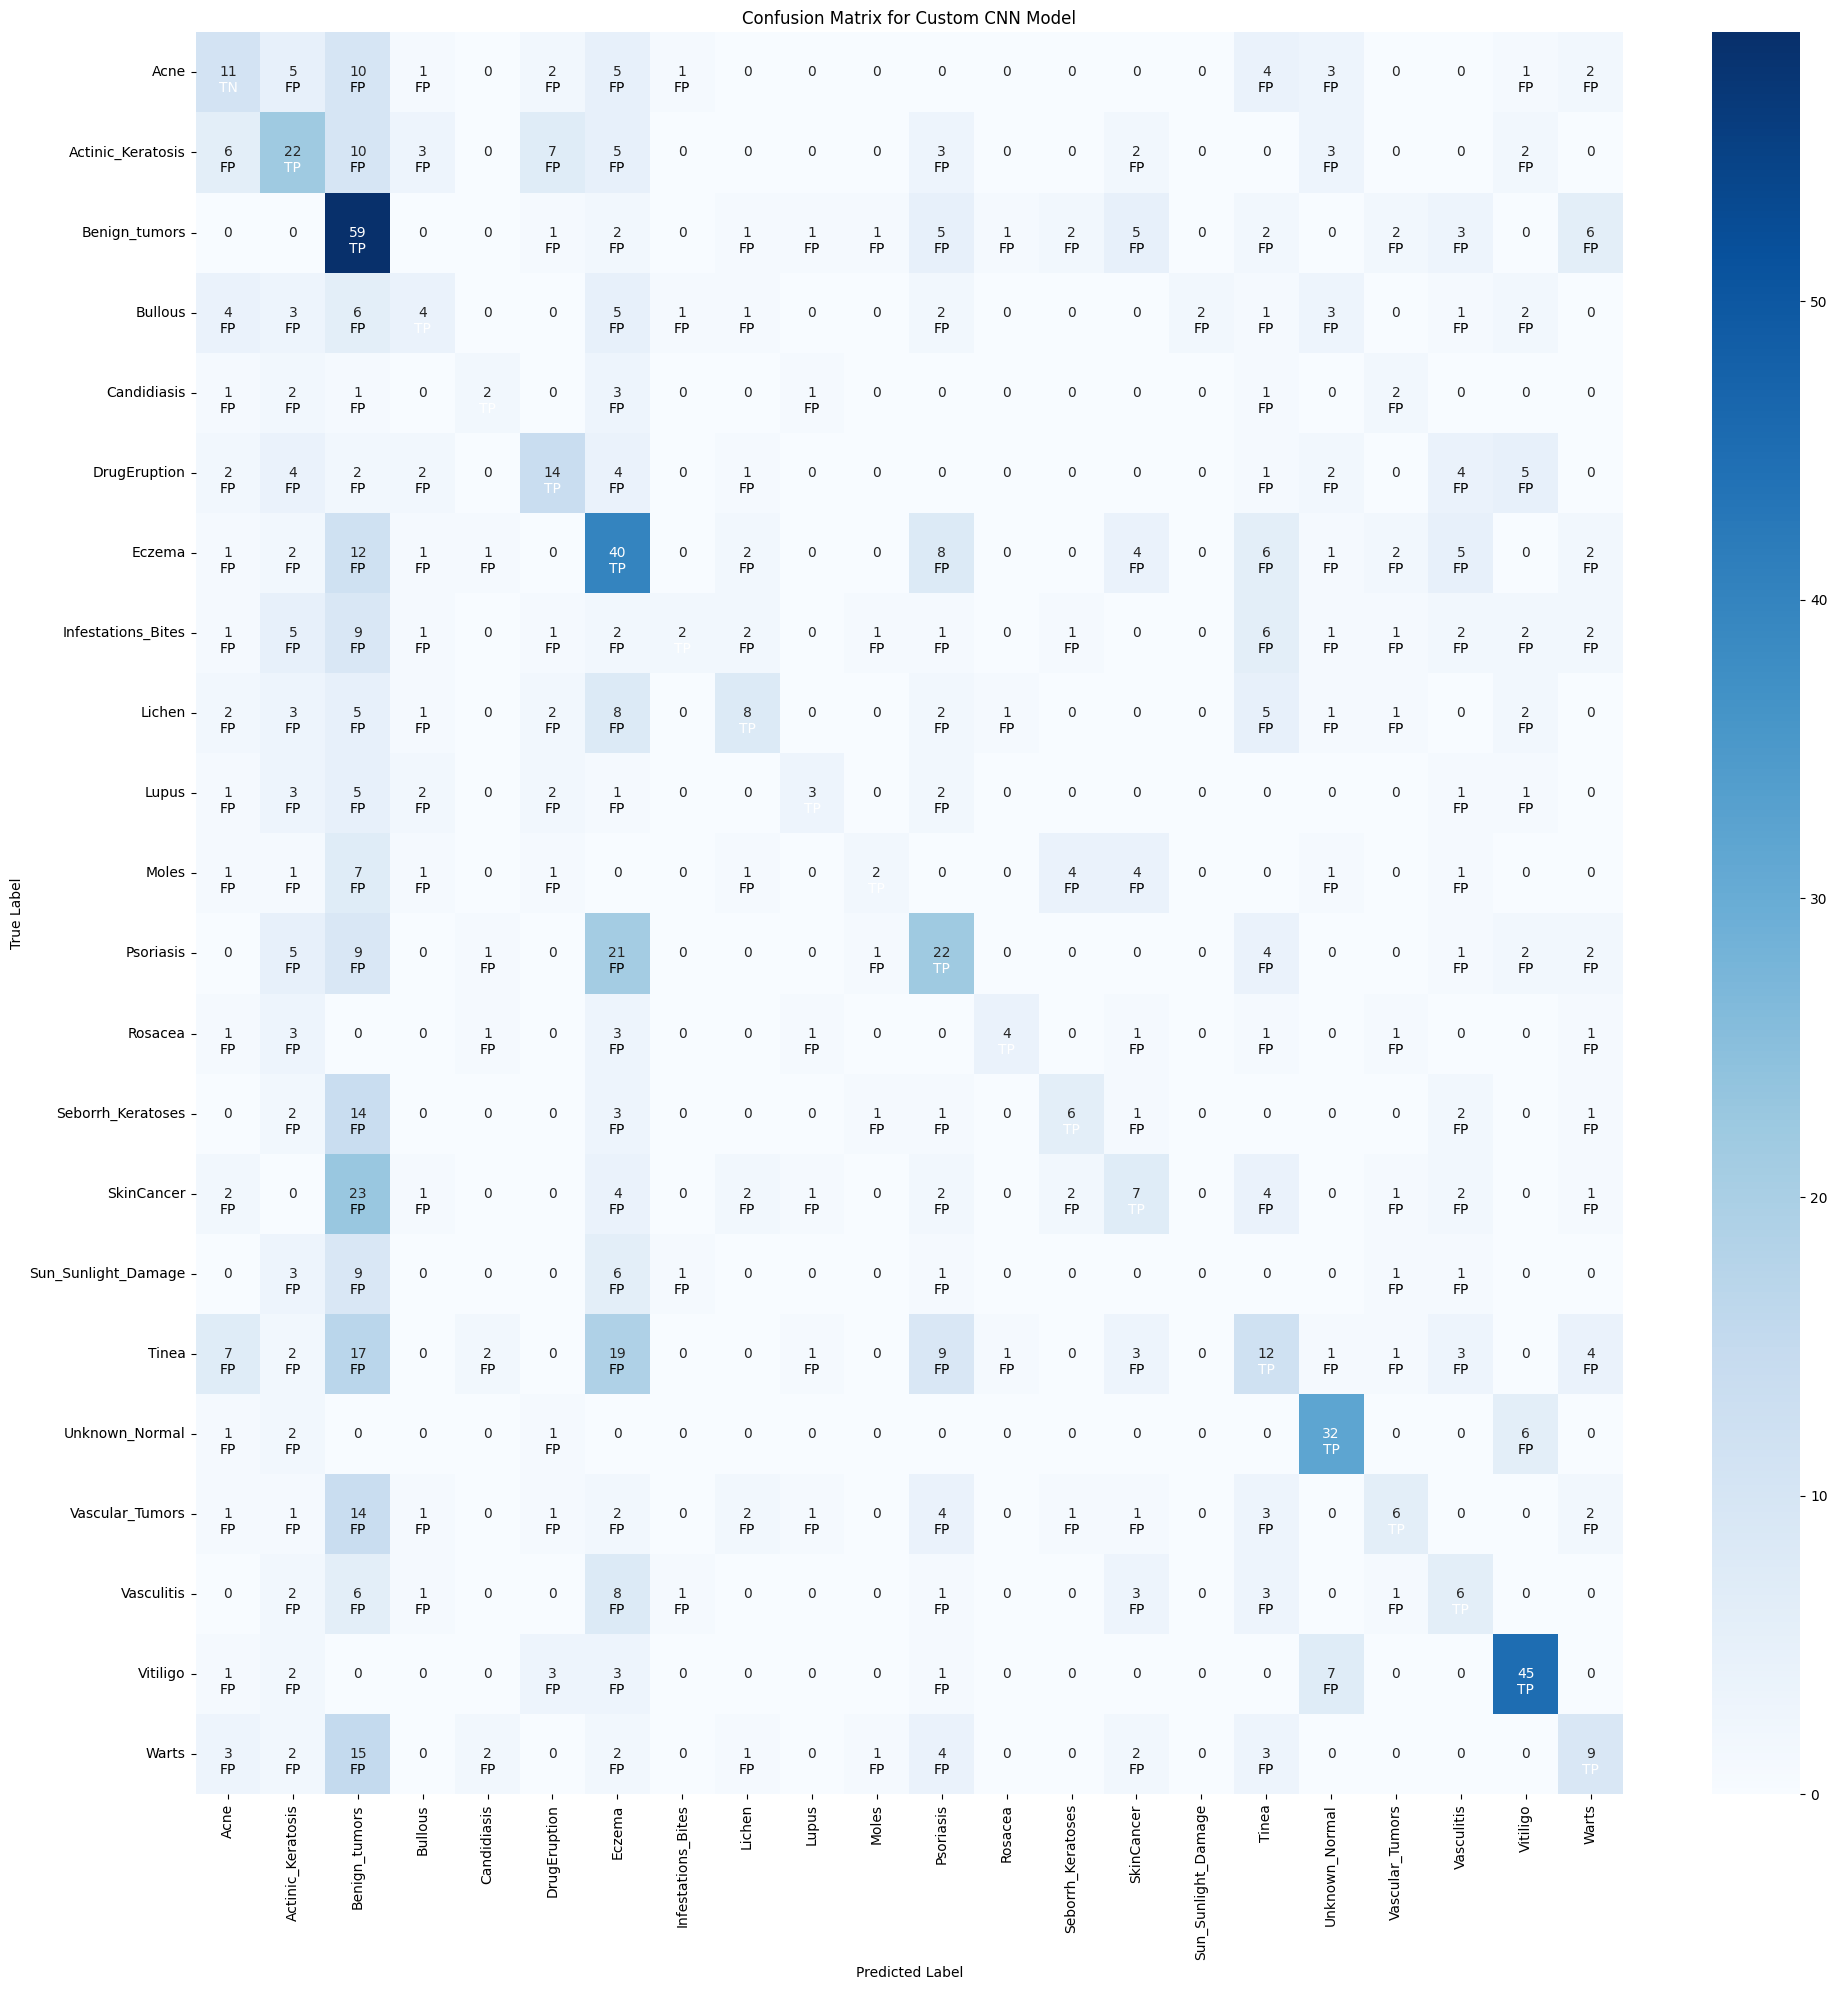

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(20, 20))
cm_features = confusion_matrix(y_true_features, y_pred_features)

plot_confusion_matrix_with_labels(y_true_features, y_pred_features, class_names)

**6.3 Testing State-of-the-Art Model**

In [ ]:
# Create test data generator with DenseNet121 preprocessing
test_densenet_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create test generator
test_generator_densenet = test_densenet_generator.flow_from_directory(
    test_dataset,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Load the best DenseNet121 model
best_densenet_model = load_model('/content/drive/MyDrive/Centennial College/Deep Learning/Project Skin Disease/models/densenet121_best_model.keras')

Found 993 images belonging to 22 classes.


In [ ]:
# Evaluate the model on test data
test_loss_densenet, test_accuracy_densenet = best_densenet_model.evaluate(test_generator_densenet)
print(f"DenseNet121 Model - Test Accuracy: {test_accuracy_densenet:.4f}, Test Loss: {test_loss_densenet:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 385ms/step - accuracy: 0.6156 - loss: 1.2606
DenseNet121 Model - Test Accuracy: 0.6002, Test Loss: 1.3415


In [ ]:
# Generate predictions for confusion matrix
test_generator_densenet.reset()
y_pred_densenet = []
y_true_densenet = []

for i in range(len(test_generator_densenet)):
    images, labels = test_generator_densenet.__next__()
    predictions = best_densenet_model.predict(images)
    y_pred_densenet.extend(np.argmax(predictions, axis=1))
    y_true_densenet.extend(np.argmax(labels, axis=1))
    if len(y_true_densenet) >= test_generator_densenet.samples:
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

In [ ]:
# Generate classification report
print("\nClassification Report for DenseNet121 Model:")
print(classification_report(y_true_densenet, y_pred_densenet, target_names=class_names))


Classification Report for DenseNet121 Model:
                     precision    recall  f1-score   support

               Acne       0.68      0.80      0.73        45
  Actinic_Keratosis       0.66      0.68      0.67        63
      Benign_tumors       0.46      0.58      0.51        91
            Bullous       0.59      0.63      0.61        35
        Candidiasis       0.45      0.38      0.42        13
       DrugEruption       0.55      0.51      0.53        41
             Eczema       0.62      0.63      0.62        87
 Infestations_Bites       0.61      0.42      0.50        40
             Lichen       0.43      0.37      0.39        41
              Lupus       0.43      0.14      0.21        21
              Moles       0.38      0.42      0.40        24
          Psoriasis       0.60      0.65      0.62        68
            Rosacea       0.50      0.76      0.60        17
  Seborrh_Keratoses       0.76      0.61      0.68        31
         SkinCancer       0.68      0.

<Figure size 2000x2000 with 0 Axes>

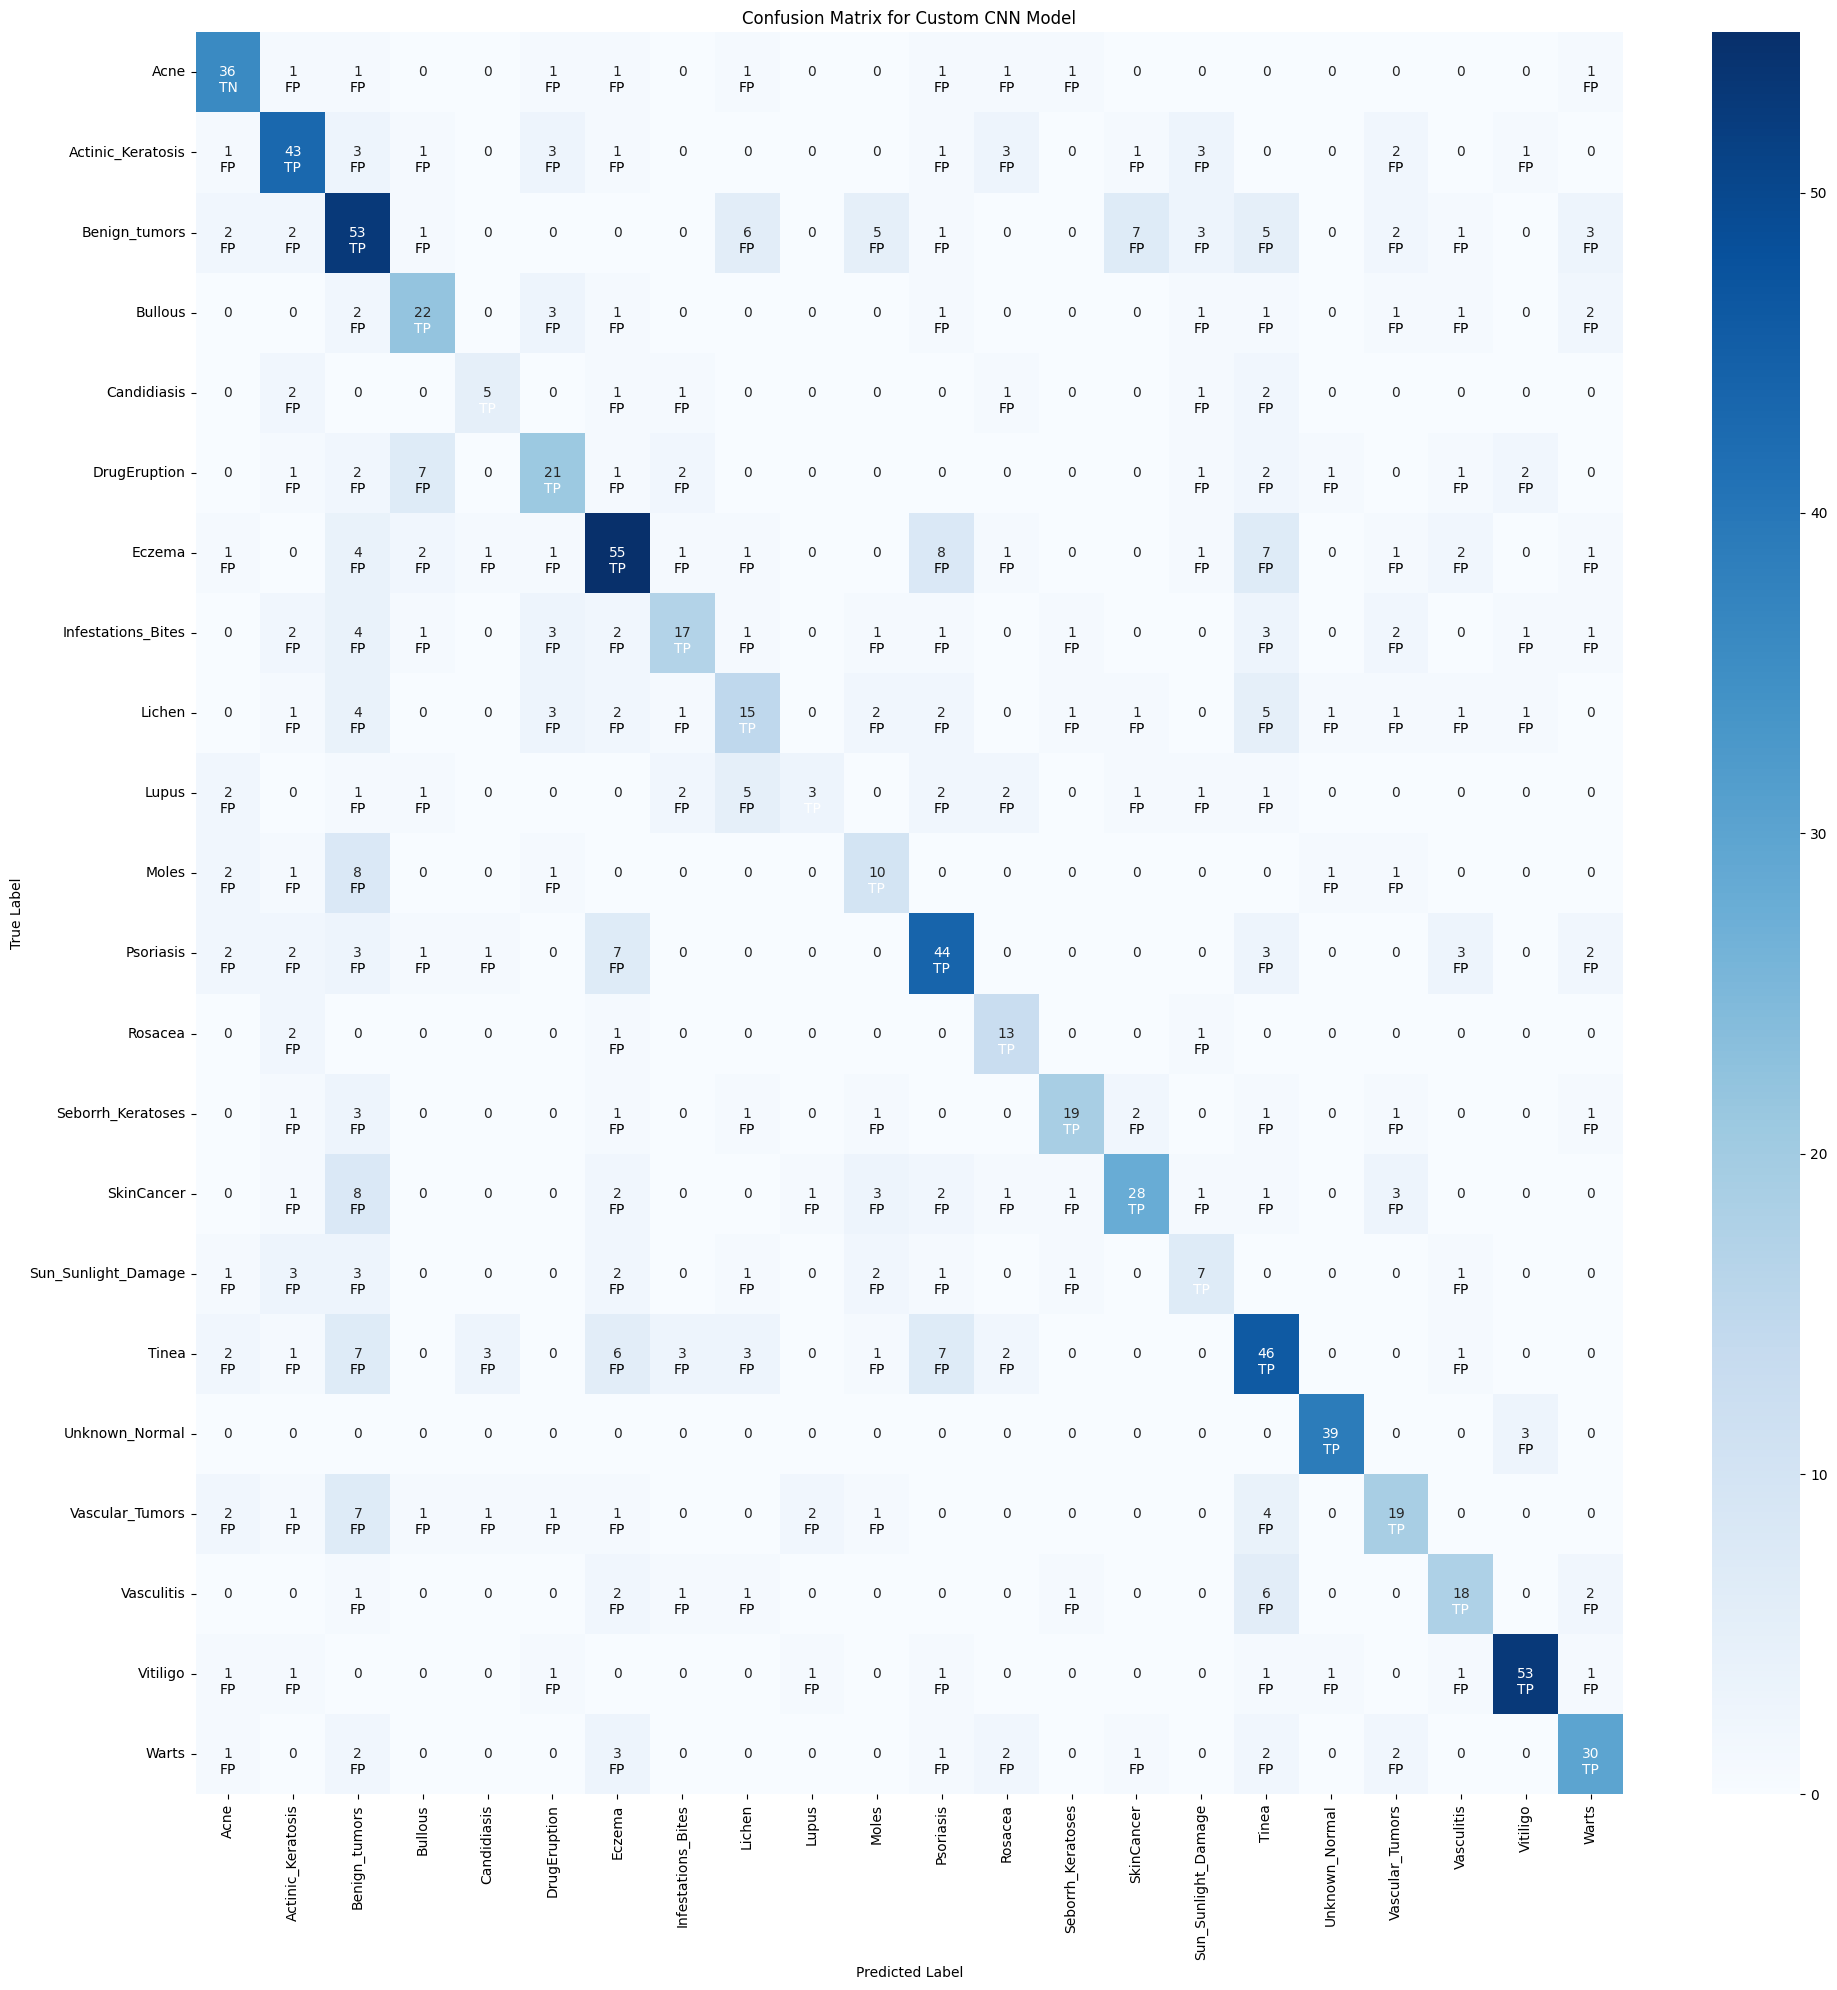

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(20, 20))
cm_densenet = confusion_matrix(y_true_densenet, y_pred_densenet)

plot_confusion_matrix_with_labels(y_true_densenet, y_pred_densenet, class_names)

# 7. Performance Comparison between all three models approaches

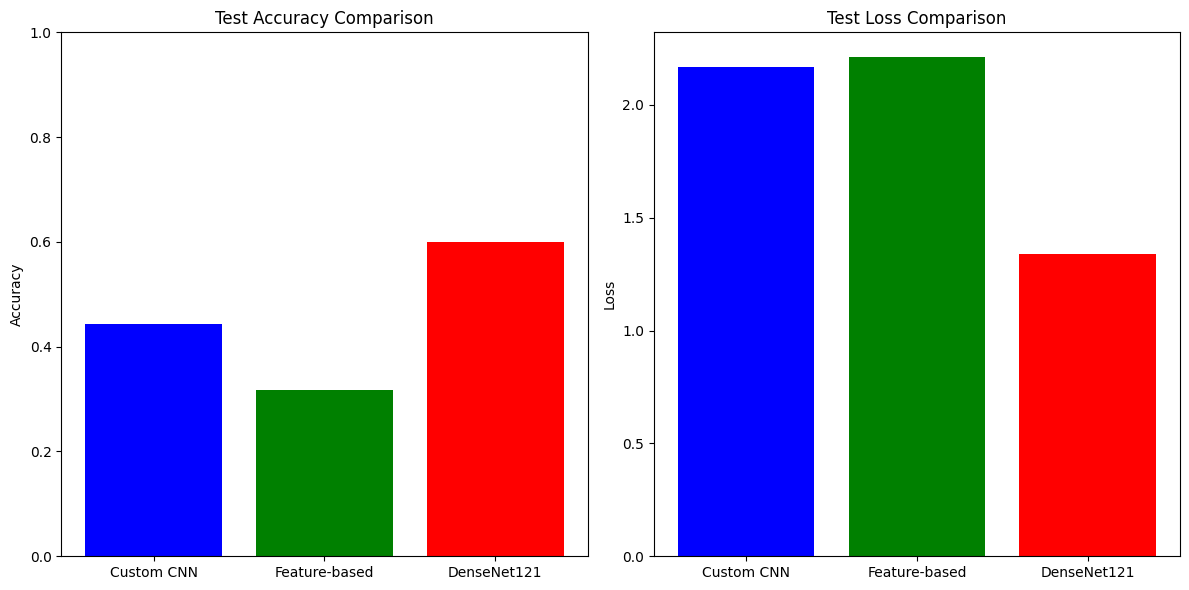

In [ ]:
# Compare the performance of all models
models = ['Custom CNN', 'Feature-based', 'DenseNet121']
accuracies = [test_accuracy, test_accuracy_features, test_accuracy_densenet]
losses = [test_loss, test_loss_features, test_loss_densenet]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.title('Test Accuracy Comparison')
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.bar(models, losses, color=['blue', 'green', 'red'])
plt.title('Test Loss Comparison')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()